# Parte 1

Los filtros de Kalman son algoritmos útilizados, en particular, para solucionar problemas dinamicos en los que estos estan condicionados a un comportamiento mutable en un tiempo discreto. Esto lo realiza mediante distintas estimaciones a priori que son corregidas a partir de distintas mediciones y ruidos relacionados al problema. La principal restriccion de estos filtros, es que funcionan solo con sistemas lineales y con distribuciones normales.

Por otra parte, en la vida real, la mayoría de problemas no tienen un comportamiento lineal, por lo que el filtro de Kalman no es muy útil. Aquí es donde encuentra cabida 'Extended Kalman Filter' (EKF). Este algoritmo linealiza los sistemas no-lineales mediante aproximaciones calculadas al elegir un punto de la ecuación a no-lineal para luego realizar 'series de Taylor' encontrando una aproximación lineal del problema.

'Unscented Kalman Filter' (UKF) también linealiza sistemas, pero en vez de realizar una aproximación mediante una 'serie de Taylor' a un punto único de la ecuación, lo realiza através de una aproximación estadistica, la cual se obtiene al realizar una 'Unscented Transformation' a una serie de valores sigma obtenidos a partir del sistema.

Debido a esto, los UKF producen un resultado aproximado mejor al obtenido a través de EKF, ya que, toma en consideración no solo 1 valor, sino, que toma una vecindad de valores para realizar este calculo. De esta forma, EKF para poder lograr una resultado similar sería necesario calcular la 'serie de Taylor' para una gran cantidad de puntos, siendo mucho más costoso computacionalmente.

# Parte 2


Iniciamos cargando los archivos desde Google Drive, para luego correr el programa.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


--------------------------------------------------------
Real state:  [0.    0.    0.    0.    0.459 1.044]
Estimated state:  [2.018e-05 0.000e+00 8.451e-05 1.057e-03 4.256e-03 2.979e-03]
Difference:  [-2.018e-05  0.000e+00 -8.451e-05 -1.057e-03  4.549e-01  1.041e+00]
--------------------------------------------------------
Real state:  [ 0.009 -0.003 -0.008  0.058  0.543  1.008]
Estimated state:  [5.326e-04 2.222e-09 1.437e-04 1.237e-02 1.496e-02 1.259e-02]
Difference:  [ 0.008 -0.003 -0.008  0.046  0.528  0.995]
--------------------------------------------------------
Real state:  [0.016 0.003 0.028 0.13  0.463 1.06 ]
Estimated state:  [3.602e-03 1.030e-06 2.627e-03 5.401e-02 2.720e-02 2.503e-02]
Difference:  [0.013 0.003 0.025 0.076 0.436 1.035]
--------------------------------------------------------
Real state:  [0.03  0.002 0.028 0.256 0.544 1.042]
Estimated state:  [1.111e-02 1.841e-05 6.577e-03 1.203e-01 5.078e-02 4.419e-02]
Difference:  [0.019 0.002 0.021 0.136 0.493 0.998]
--

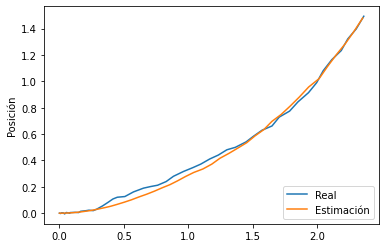

In [44]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/tarea2IA')
#!/usr/bin/env python
import matplotlib.pyplot as plt
from ukf import UKF
import csv
import numpy as np
import math
def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret
def main():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            print ("--------------------------------------------------------")
            print ("Real state: ", real_state)
            print ("Estimated state: ", state_estimator.get_state())
            print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.ylabel('Posición')
    plt.show()

if __name__ == "__main__":
    main()

# Parte 3

Para esta parte, generaremos graficos para cada caso donde el titulo del grafico señala cuales sensores se ocupan, y en caso de que no se ocupe, no se menciona el sensor en el titulo. Además, se omitieron los resultados númericos para que exista una mejor visualización de los graficos obtenidos y así poder compararlos con mayor facilidad.

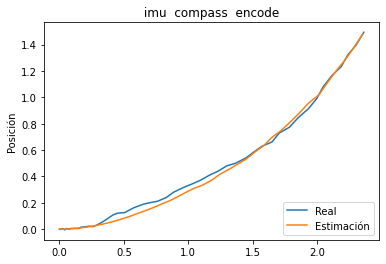

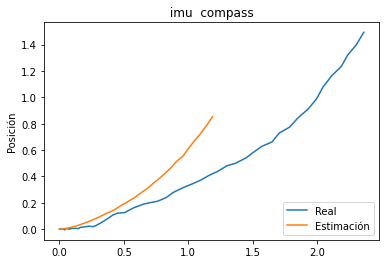

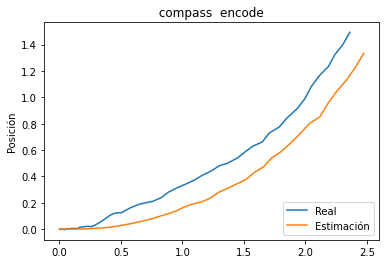

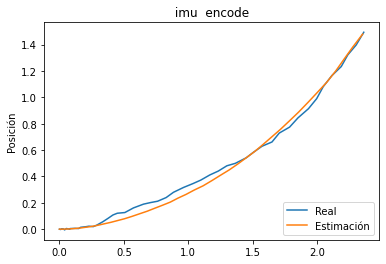

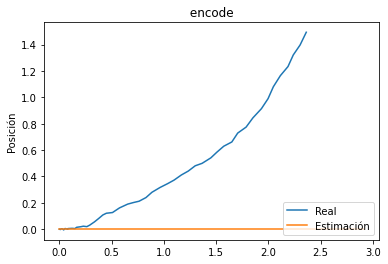

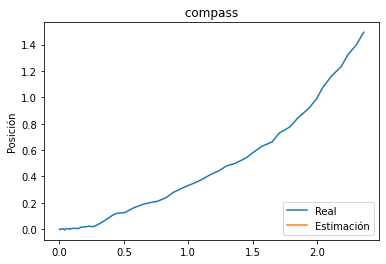

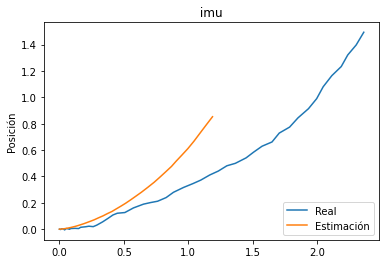

In [45]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/tarea2IA')
#!/usr/bin/env python
import matplotlib.pyplot as plt
from ukf import UKF
import csv
import numpy as np
import math
def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret
def main(imu, compass, encode): 
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    text = ''
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            if imu == 1: 
              state_estimator.update([4, 5], imu_data, r_imu) 
            if compass == 1: 
              state_estimator.update([2], compass_data, r_compass)      
            if encode == 1: 
              state_estimator.update([3], encoder_vel, r_encoder)    

            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    if imu == 1: text+=' imu ' 
    if compass == 1: text+=' compass '
    if encode == 1: text+=' encode '
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.ylabel('Posición')
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.title(text)
    plt.show()

if __name__ == "__main__":
    main(1,1,1)
    main(1,1,0)
    main(0,1,1)
    main(1,0,1)
    main(0,0,1)
    main(0,1,0)
    main(1,0,0)
    
    

Al observar los resultados concluimos que ningún sensor sirve por sí solo, es más, solamente el imu con el encode logra un resultado cercano a la medición real. 

Sin embargo, se nota una clara diferencia entre posición real y la estimación cuando se usan menor sensores, concluyendo que para el problema son los 3 completamente necesarios.

#Parte 4


Para verificar lo que sucede con un aumento en la covarianza se realizan distintas pruebas. Primero una modificación pequeña al ruido del modelo agregando 0.0005 a cada q, para otra pruba se multiplica cada valor origianal por 5. Para las pruebas con el ruido de los sensores se agrego 0.0005 a los sensores IMU. Finalmente, se observa el cambio con ambos cambios a la vez.

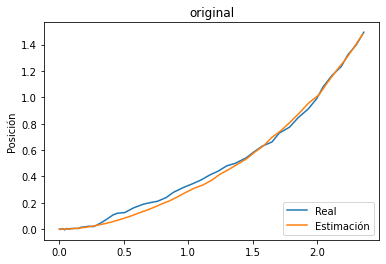

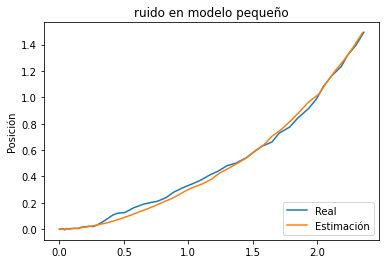

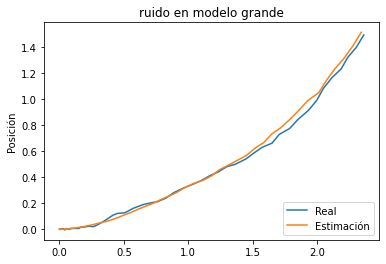

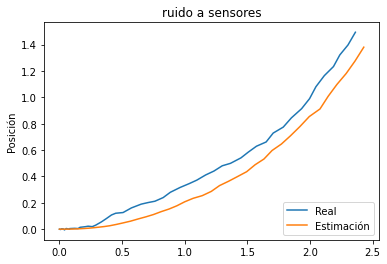

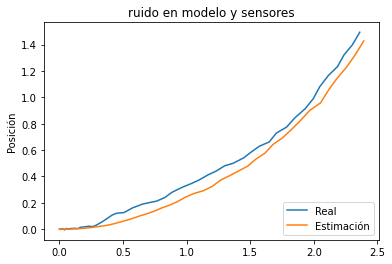

In [60]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/tarea2IA')
#!/usr/bin/env python
import matplotlib.pyplot as plt
from ukf import UKF
import csv
import numpy as np
import math
def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret
def main():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.title('original')
    plt.ylabel('Posición')
    plt.show()

def main_qchange_l():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0006
    q[1][1] = 0.0006
    q[2][2] = 0.0009
    q[3][3] = 0.0030
    q[4][4] = 0.0030
    q[5][5] = 0.0030
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.ylabel('Posición')
    plt.title('ruido en modelo pequeño')
    plt.show()

def main_qchange_m():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0005
    q[1][1] = 0.0005
    q[2][2] = 0.0020
    q[3][3] = 0.0125
    q[4][4] = 0.0125
    q[5][5] = 0.0125
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.ylabel('Posición')
    plt.title('ruido en modelo grande')
    plt.show()


def main_rchange():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.06
    r_imu[1][1] = 0.08
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.ylabel('Posición')
    plt.title('ruido a sensores')
    plt.show()

def main_ryqchange():
    np.set_printoptions(precision=3)
    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0004
    q[1][1] = 0.0008
    q[2][2] = 0.0009
    q[3][3] = 0.0030
    q[4][4] = 0.0040
    q[5][5] = 0.0050
    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.06
    r_imu[1][1] = 0.08
    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02
    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001
    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    x_real = [] #Creamos arreglo para guardar valores de x e y
    y_real = []
    x_ukf = []
    y_ukf = []
    with open('/content/drive/MyDrive/Colab Notebooks/tarea2IA/datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        last_time = 0
        # read data
        for row in reader:
            row = [float(x) for x in row]
            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])
            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])
            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])
            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])
            last_time = cur_time
            # prediction is pretty simple
            state_estimator.predict(d_time)
            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)
            #print ("--------------------------------------------------------")
            #print ("Real state: ", real_state)
            #print ("Estimated state: ", state_estimator.get_state())
            #print ("Difference: ", real_state - state_estimator.get_state())
            x_real.append(real_state[0])
            y_real.append(real_state[1])
            x_ukf.append(state_estimator.get_state()[0])
            y_ukf.append(state_estimator.get_state()[1])
    plt.plot(x_real,y_real,x_ukf,y_ukf)
    plt.legend(["Real", "Estimación"], loc ="lower right")
    plt.title('ruido en modelo y sensores')
    plt.ylabel('Posición')
    plt.show()

if __name__ == "__main__":
    main()
    main_qchange_l()
    main_qchange_m()
    main_rchange()
    main_ryqchange()

Como se observa, el cambio en la covarianza en el ruido del modelo no produce un cambio significativo. Por otra parte, el cambio en el sensor IMU produjo un cambio significativo, concluyendo que el ruido de los sensores son claramente importantes para obtener un buen resultado.